# Comparing the performance of non-supervised vs supervised learning methods for text classification

## Methodology

The following data science techniques will be demonstrated:

1. Load and process text from the newsgroups in sklearn

2. Convert documents to numeric formats  
    (i) Build count_vectorizer from the documents and fit the documents  
    (ii) Build TF (Term Frequency) from the documents, this is a sparse version of the bag-of-words  
    (iii) Build bag-of-words in two steps: fit, transform  
    (iv) Get feature names and build dataframe version of the bag-of-words  
    (v) Use TfidfTransformer to transform bag_of_words intoTF-IDF matrix (Term Frequency - Inverse Document Frequency)  
    (vi) Find most popular words and highest weights  
    (vii) Build word weights as a list and sort them  
    (viii) Calculate cosine similarity of all documents with themselves  
    (ix) Calculate distance matrix of documents  

3. Apply PCA for Dimensionality Reduction

4. Unsupervised classification for topic analysis  
(i) K-means clusters  - based on PCA from step 3  
(ii) NMF (Non-negative Matrix Factorization) - based on TF-IDF from step 2(v)  
(iii) LDA (Latent Dirichlet Allocation)  - based on TF from step 2(ii)

5. Compare cluster outputs for Unsupervised Learning

6. Compare Unsupervised Learning methods to sklearn documentation example for Supervised Learning







## 1  Load and process text from the newsgroups in sklearn

In [0]:
# Setup
!pip install -q wordcloud
import wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import unicodedata
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn import metrics
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS  # a longer list of stopwords than nltk

pd.set_option("display.precision", 4)
np.set_printoptions(precision=4)

## Download the news documents and print class distribution

In order to enable faster execution times we will work on a partial dataset with only 4 categories out of the 20 available in the dataset.   
We will download and use the test set version which will enable us to compare results with the example presented in the sklearn documentation here:

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Note that for this tutorial we do not split the process into train and test processes since we will run a straightforward cluster analysis on the test set in order to be able to compare the unsupervised learning performance with that of the documented supervised learning. We will only 'peek' at the class labels at the end of the process in order to measure the performance of our unsupervised learning methods and compare them to the documentation results for the supervised learning methods.

In [2]:
from sklearn.datasets import fetch_20newsgroups
CATEGORIES = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

IS_TRAIN_SET = False  # get the test set so that we can compare performance to the one documented on the above scikit web page

if IS_TRAIN_SET:
  news_docs = fetch_20newsgroups(subset='train', categories=CATEGORIES, shuffle=True, random_state=42)
else:
  news_docs = fetch_20newsgroups(subset='test', categories=CATEGORIES, shuffle=True, random_state=42)

TARGET_NAMES = news_docs.target_names
print("TARGET_NAMES:", TARGET_NAMES)
print("len(news_docs.data):", len(news_docs.data))

print(type(news_docs))
data_samples = news_docs.data
data_classes = news_docs.target
print("data_classes:", data_classes)

n_topic_clusters = np.unique(data_classes).shape[0]
print("n_topic_clusters:", n_topic_clusters)

print("Class distribution:")
print(pd.Series(data_classes).value_counts())

TARGET_NAMES: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']
len(news_docs.data): 1502
<class 'sklearn.utils.Bunch'>
data_classes: [2 2 2 ... 2 2 1]
n_topic_clusters: 4
Class distribution:
3    398
2    396
1    389
0    319
dtype: int64


## Get packages

In [3]:
#@title
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
domain_stopwords = ['subject', 'organization', 'lines', 'from', 'reply-to', 'distribution', 'keywords', 'article', 'newsreader', 'nntp-posting-host', 'writes', 'x-newsreader', 'summary']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Helper functions for the preprocessing

In [0]:
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

## Preprocessing main function

---
Before removing POS that are not nouns and lemmatization:
df_token_lists.shape: (1502, 1200)
df_token_lists.head(5):
        0              1           2       3      4          5            6        7         8           9           10       11        12       13         14           15        16     17        18       19          20          21          22             23           24        25      26          27        28        29       30         31          32          33     34         35         36        37      38      39           40         41          42       43         44        45           46          47        48      49          50     51         52       53   54     55    56         57         58             59       60          61     62         63       64    65       66        67         68         69    70      71       72      73        74       75         76           77         78              79       80         81   82      83   84    85          86    

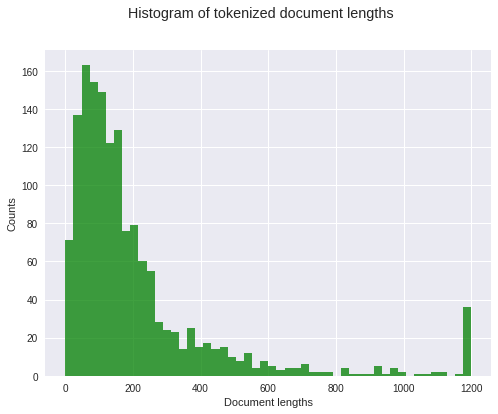

In [5]:
def preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=False, is_plot=False):
  '''
  Preprocess documents
  
  Parameters:
  data_samples: list of data samples
  data_classes: list of classes
  general_stopwords: list of stopwords used in general
  domain_stopwords: domain specific stopwords that should not appear in the word cloud
  stemmer: the stemmer method
  lemmatizer: the lemmatizer method
  is_skip_header: boolean to skip the header section in each newsgroup
  
  Return:
  df_token_lists: dataframe of tokenized word lists
  df_lem_strings: dataframe of lemmatized word lists
  data_samples_processed: list of the processed lemmatized strings
  data_processed: list of tuples of data_samples_processed and their data classes
  '''

  # POS (Parts Of Speech)
  # For: nouns, adjectives, verbs and adverbs use {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
  DI_POS_TYPES = {'NN':'n'}  # Just the nouns
  POS_TYPES = list(DI_POS_TYPES.keys())

  # Constraints on tokens
  MIN_STR_LEN = 3
  MAX_TOKENS = 1200
  RE_VALID = '[a-zA-Z]'
  PUNCT = ['@', '_', '.']

  # Process all data samples
  li_tokens = []
  li_token_lists = []
  li_lem_strings = []
  len_tokens = []
  
  for i,text in enumerate(data_samples):

      # Tokenize by sentence, then by lowercase word
      tokens = []
      if is_skip_header:
        # Skip most of the first section that represents the header metadata
        for j,sent in enumerate(nltk.sent_tokenize(text)):
          if j == 0:
            li_sents = [s.strip() for s in sent.splitlines()]
            li_sents = [s for s in li_sents if len(s) > 0 and not s.lower().startswith(tuple(domain_stopwords))]
            tokens0 = [token.lower() for sent in li_sents for token in nltk.word_tokenize(sent)]
            tokens = []
            for t in tokens0:
              is_in = False
              for p in PUNCT:
                if p in t:
                  is_in = True
                  break
                  
              if not is_in:    
                tokens.append(t)
              
            continue

          for word in nltk.word_tokenize(sent):
            tokens.append(word.lower())
      else:
        tokens = [token.lower() for sent in nltk.sent_tokenize(text) for token in nltk.word_tokenize(sent)]
      
      # Remove stopwords
      tokens = [x for x in tokens if x not in general_stopwords]
      tokens = [x for x in tokens if x not in domain_stopwords] 
      
      # Limit
      tokens = tokens[:MAX_TOKENS]
      len_tokens.append(len(tokens))

      # Process all tokens per quote
      li_tokens_quote = []
      li_tokens_quote_lem = []
      for token in tokens:
          # Remove email addresses
          if '@' in token:
            continue
          
          # Remove accents
          t = remove_accents(token)

          # Remove misc
          t = remove_misc(t)

          # Remove punctuation
          t = str(t).translate(string.punctuation)
          li_tokens_quote.append(t)

          # Add token that represents "no lemmatization match"
          li_tokens_quote_lem.append('-') # this token will be removed if a lemmatization match is found below

          # Process each token
          if t not in general_stopwords:
              if re.search(RE_VALID, t):
                  if len(t) >= MIN_STR_LEN:
                      # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                      # (otherwise it assumes the word is a noun)
                      pos = nltk.pos_tag([t])[0][1][:2]
                      pos2 = 'n'  # set default to noun
                      if pos in DI_POS_TYPES:
                        pos2 = DI_POS_TYPES[pos]

                      stem = stemmer.stem(t)
                      lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS

                      if pos in POS_TYPES:
                          li_tokens.append((t, stem, lem, pos))

                          # Remove the '-' token and append the lemmatization match
                          li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                          li_tokens_quote_lem.append(lem)

      # Build list of token lists from lemmatized tokens
      li_token_lists.append(li_tokens_quote)

      # Build list of strings from lemmatized tokens
      str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
      li_lem_strings.append(str_li_tokens_quote_lem)

  # Build resulting dataframes from lists
  df_token_lists = pd.DataFrame(li_token_lists)

  # Replace None with empty string
  for c in df_token_lists:
      if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
          df_token_lists[c].fillna(value='', inplace=True)

  df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem string'])

  # Build a dataset that corresponds the processed strings to the class labels
  data_samples_processed = [x.replace('-','') for x in li_lem_strings]
  data_processed = list(zip(data_classes, data_samples_processed))
  
  if is_print:
    print("---")
    print("Before removing POS that are not nouns and lemmatization:")
    print("df_token_lists.shape:", df_token_lists.shape)
    print("df_token_lists.head(5):")
    print(df_token_lists.head(5).to_string())
    
    print("---")
    print("After removing POS that are not nouns and lemmatization:")
    print("df_lem_strings.head():")
    print(df_lem_strings.head().to_string())
    
    print("---")
    for i,v in enumerate(data_processed[:5]):
      print(i,v)

  # Plot histogram of tokenized document lengths
  if is_plot:
    fig = plt.figure(figsize=(8,6))
    plt.suptitle("Histogram of tokenized document lengths")
    plt.xlabel("Document lengths")
    plt.ylabel("Counts")
    n, bins, patches = plt.hist(len_tokens, bins=50, density=False, facecolor='g', alpha=0.75)
    plt.show()
  
  return df_token_lists, df_lem_strings, data_samples_processed, data_processed

# Preprocess documents
df_token_lists, df_lem_strings, data_samples_processed, data_processed = \
  preprocess_documents(data_samples, data_classes, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True, is_print=True, is_plot=True)


## 2  Convert documents to numeric formats  

In [0]:
# Build tf-idf vectorizer and related variables from the input documents
# to support both unigrams and bigrams use: ngram_range=(1,2)
def build_vectorizer(documents, ngram_range=(1,1), max_df=1.0, min_df=1, stop_words=None, max_features=None):   # default CountVectorizer parameter values
    '''
    (i) Build count_vectorizer from the documents and fit the documents  
    (ii) Build TF (Term Frequency) from the documents, this is a sparse version of the bag-of-words  
    (iii) Build bag-of-words in two steps: fit, transform  
    (iv) Get feature names and build dataframe version of the bag-of-words  
    (v) Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)  
    (vi) Find most popular words and highest weights  
    (vii) Build word weights as a list and sort them  
    (viii) Calculate cosine similarity of all documents with themselves  
    (ix) Calculate distance matrix of documents  
    
    Note:
    The TF_IDF matrix can be built directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec: CountVectorizer
    tf: Term Frequencies
    tfidf: TF-IDF matrix 
    feature_names: Feature names in TF-IDF
    df_bag_of_words: Bag of words from the sparse Term Frequencies
    df_weights: Most popular words, word counts and highest weights
    cos_sim: Cosine similarity of all documents with themselves
    samp_dist: Distance matrix of documents
    '''
    
    # Build CountVectorizer from the documents and fit the documents
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df, stop_words=stop_words, max_features=max_features)
    
    # Build TF (Term Frequencies) from the documents, this is a sparse version of the bag-of-words
    tf = count_vectorizer.fit_transform(documents)  # note that the LDA transform needs this for its clustering model (explained below)

    # Build bag-of-words in two steps: fit, transform
    cvec = count_vectorizer.fit(documents)
    bag_of_words = cvec.transform(documents)
    
    # Get feature names and build dataframe version of the bag-of-words
    feature_names = cvec.get_feature_names()
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words, word counts and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them (the dataframe below also contains the counts)
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Calc cosine similarity of all documents with themselves
    cos_sim = metrics.pairwise.cosine_similarity(tfidf, tfidf)

    # Calc distance matrix of documents
    samp_dist = 1 - cos_sim

    return cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist
  
# Build TF-IDF matrices
li_lem_strings = df_lem_strings['lem string'].values.tolist()
cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = build_vectorizer(li_lem_strings)

## Build a word cloud from the weighted word counts

Word cloud based on all categories:
         word  count  weight
0         god   1287  0.0275
1      people    805  0.0164
2       think    709  0.0160
3   christian    552  0.0146
4        time    655  0.0139
5  university    399  0.0133
6        book    434  0.0129
7       image    561  0.0128
8      church    460  0.0121
9      thanks    221  0.0121


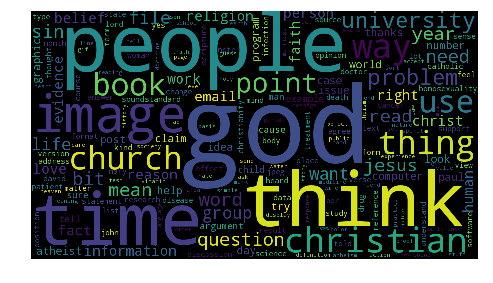

In [7]:
def word_cloud(df_weights, n_top_words=10, is_print=True, is_plot=True):
  '''
  Build a word cloud
  '''
  s_word_freq = pd.Series(df_weights['count'])
  s_word_freq.index = df_weights['word']
  di_word_freq = s_word_freq.to_dict()
  cloud = wordcloud.WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
 
  if is_print:
    print(df_weights.iloc[:n_top_words,:])
  
  if is_plot:
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
  
  return cloud
  
# Build word cloud
print("Word cloud based on all categories:")
cloud_all = word_cloud(df_weights, is_print=True)

This is a mixed-up mess, let's see what happens when we analyse the newsgroups separately.

## Build word clouds for each class separately

In [0]:
def word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True):
  print("Category:", TARGET_NAMES[i_class])
  print("----------------------------------")
  data_samples_group = [x for i,x in enumerate(data_samples) if data_classes[i] == i_class]
  data_classes_group = [i_class] * len(data_samples_group)
  
  # Preprocess documents
  df_token_lists_per_class, df_lem_strings_per_class, data_samples_processed_per_class, data_processed_per_class = \
    preprocess_documents(data_samples_group, data_classes_group, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header)
  
  # Build TF-IDF matrices
  li_lem_strings = df_lem_strings_per_class['lem string'].values.tolist()
  cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = \
    build_vectorizer(li_lem_strings)

  # Build word cloud
  cloud = word_cloud(df_weights)
  return cloud

Category: alt.atheism
----------------------------------
       word  count  weight
0       god    331  0.0373
1   atheist    178  0.0277
2  religion    198  0.0269
3     think    236  0.0263
4    people    234  0.0230
5    belief    193  0.0216
6      book    153  0.0205
7      time    180  0.0196
8     claim    140  0.0172
9      mean    137  0.0172


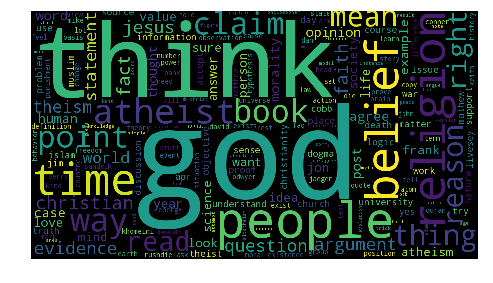

In [9]:
i_class = 0
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: comp.graphics
----------------------------------
         word  count  weight
0       image    505  0.0354
1         bit    323  0.0327
2        file    303  0.0314
3      thanks    111  0.0251
4     graphic    226  0.0247
5      format    168  0.0237
6     program    189  0.0234
7    computer    206  0.0222
8  university    154  0.0211
9       email    129  0.0177


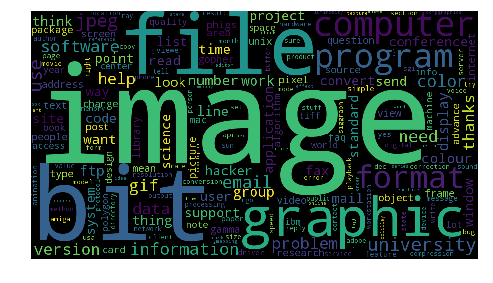

In [10]:
i_class = 1
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: sci.med
----------------------------------
          word  count  weight
0       doctor    169  0.0192
1         drug    155  0.0178
2       people    161  0.0164
3       effect    136  0.0158
4      patient    193  0.0152
5  information    106  0.0152
6         time    155  0.0150
7   university    101  0.0149
8          use    147  0.0143
9        think    125  0.0143


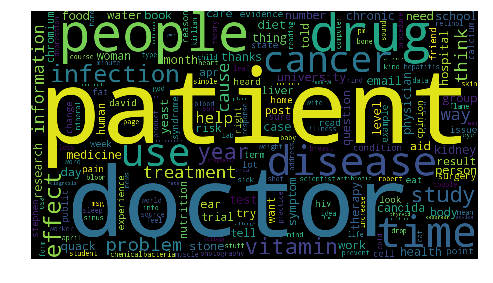

In [11]:
i_class = 2
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

Category: soc.religion.christian
----------------------------------
        word  count  weight
0        god    922  0.0539
1  christian    436  0.0333
2        sin    375  0.0329
3     church    401  0.0315
4     people    351  0.0255
5       mary    159  0.0254
6      jesus    254  0.0240
7     christ    272  0.0229
8      think    275  0.0222
9       book    175  0.0221


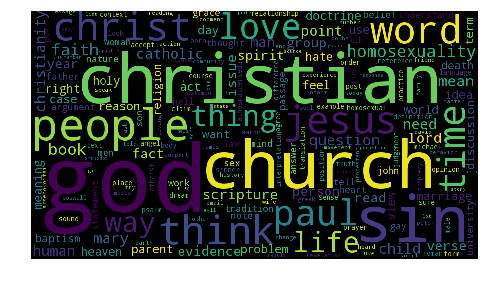

In [12]:
i_class = 3
word_cloud_per_class(i_class, data_samples, general_stopwords, domain_stopwords, stemmer, lemmatizer, is_skip_header=True)

## 3 Apply PCA for Dimensionality Reduction

Before  **clustering** the data, we will usually want to do **dimensionality reduction** of the data in order to reduce the risk of overfitting to features that have a low signal to noise ratio. Note the distinction between the two terms:

* **Dimensionality reduction**: find the linear combinations of variables that are most 'interesting' in the data. For example, the polular PCA technique finds linear transformations of input features that maximize the variance of the data points along the new axes.

* **Clustering**: find data points that can be grouped together as separate classes.

In [13]:
# Dimensionality reduction using PCA
# Reduce the tfidf matrix to just 2 features (n_components)
X = tfidf.todense()
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca[:5,:])

print("---")
print("X.shape:", np.array(X).shape)
print("X_pca.shape:", np.array(X_pca).shape)

X_pca now has just 2 columns:
[[-0.0406 -0.0854]
 [-0.066  -0.1761]
 [-0.0278 -0.0627]
 [ 0.0537 -0.0843]
 [ 0.0192 -0.001 ]]
---
X.shape: (1502, 17471)
X_pca.shape: (1502, 2)


##4 Unsupervised classification for topic analysis

We will use 3 different methods:

(i) K-means clusters - based on PCA from step 3  
(ii) NMF (Non-negative Matrix Factorization) - based on TF-IDF from step 2(v)  
(iii) LDA (Latent Dirichlet Allocation) - based on TF from step 2(ii)  

## 4(i) K-means clusters  - based on PCA from step 3

K-means is one of the most popular clustering alogirthms for non-supervised classification.  
See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [14]:
# Note that for this simplistic dataset we don't really need to iterate
# and usually we don't know the number of topic clusters in advance!
km_model = KMeans(n_clusters=n_topic_clusters, max_iter=10, n_init=2, random_state=0)

# K-means (transform dimensions from number of features in input matrix to n_clusters)
km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

print("df_centers:")
print(df_centers)

df_centers:
        x       y
0  0.2312  0.0774
1 -0.0492 -0.0336
2 -0.1414  0.1725
3  0.0664 -0.0178


In [15]:
# K-means model labels and actual document labels
df_documents = pd.DataFrame(data_processed, columns=['Label', 'Document'])
print(df_documents.head())

actual_labels = df_documents['Label'].tolist()
km_model_labels = km_model.labels_.tolist()

   Label                                           Document
0      2  recall bout kidney stone   medication relieve ...
1      2    banschbach    class  question   use patient ...
2      2    chorley       gtclark    clark     msnyder  ...
3      0     bil  conner       atheist  argue parody   r...
4      3   juxtaposition ancient text   sacramentis     ...


## K-means scatter plots with labels

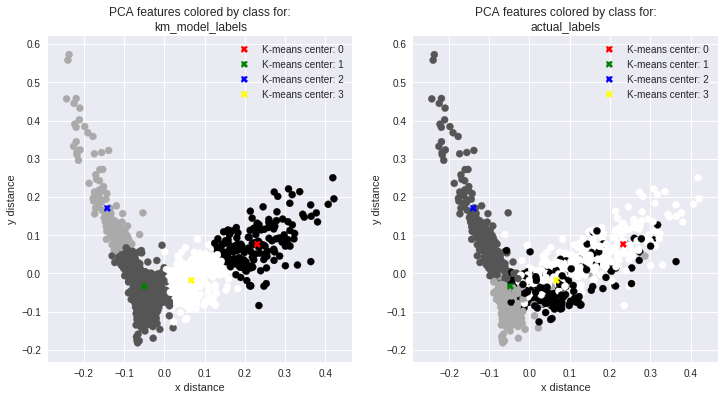

In [16]:
def scatter_plot_with_labels(i_plot, df_centers, labels, title):
  ax = plt.subplot(1, 2, i_plot)
  ax.set_title('PCA features colored by class for:\n' + title)
  ax.set_xlabel('x distance')
  ax.set_ylabel('y distance')
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='gray')

  colors = ['red', 'green', 'blue', 'yellow']
  for i,color in enumerate(df_centers.index.tolist()):
    plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])

  plt.legend()

plt.figure(figsize=(12,6))
scatter_plot_with_labels(1, df_centers, km_model_labels, "km_model_labels")
scatter_plot_with_labels(2, df_centers, actual_labels, "actual_labels")
plt.show()

## Remap the color of the above indexes based on an inspection of the above

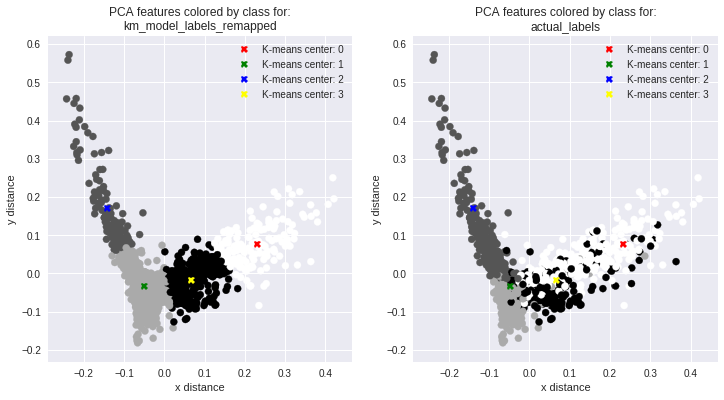

In [17]:
# di_actual_to_kmeans = {0:0, 1:1, 2:2, 3:3}  # no color remapping
di_actual_to_kmeans = {0:3, 1:2, 2:1, 3:0}
km_model_labels_remapped = [di_actual_to_kmeans[x] for x in km_model_labels]

plt.figure(figsize=(12,6))
scatter_plot_with_labels(1, df_centers, km_model_labels_remapped, "km_model_labels_remapped")
scatter_plot_with_labels(2, df_centers, actual_labels, "actual_labels")
plt.show()

* K-means results in a clean segmentation of all the data points (on the left).   

* Of course there are some classification errors as can be seed on the right but we can still clearly see the 4 clusters.

* Note that since we usually do not know the number of clusters in the data, we need to estimate this using a techique such as the popular **Elbow method**:  
https://en.wikipedia.org/wiki/Elbow_method_(clustering)

* The dimensions of the centers are: (n_clusters, n_features).   

* The PCA was run as an initial step prior to the K-means which resulted in the above 2 dimensional representation (n_features = 2).   

In [0]:
# The cluster functions below take a dataframe of the tfidf as input (this includes the column labels)
df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)

In [0]:
# Constants

def calc_top_topics(model_type, model_components, model_transform, df_tfidf, df_documents, n_top_words, n_top_documents, is_print=False):
    '''
    Calculate the top topics for a clustering model
    
    Parameters:
    model_type: 'NMF' or 'LDA' model
    model_components: sklearn model components
    model_transform: sklearn model transform
    df_tfidf: dataframe of TF-IDF which includes the feature names
    df_documents: dataframe of documents in the corpus
    n_top_words: number of top words per cluster
    n_top_documents: number of top documents per cluster
    
    Return:
    all_top_words_per_cluster: all the top words per topic cluster
    all_top_doc_idxs_per_cluster: all the top document indexes per topic cluster 
    all_top_cluster_idxs_per_doc: all the top cluster indexes per document 
    best_cluster_idx_per_doc: the best cluster index per doc
    
    '''
    
    feature_names = df_tfidf.columns
    
    if is_print:
      print("Model type:", model_type)
      print("model_components [topic clusters, words]:")
      print("(for NMF, this is the H matrix [n_components, n_features]")
      print(model_components)
      print("---")

      print("model_transform [documents, topic clusters]:")
      if model_type == 'NMF':
        print("(for NMF, this is the W matrix: [n_samples, n_components])")    

      print(model_transform)
      print("---")
      
    # Cluster analysis per document
    all_top_cluster_idxs_per_doc = []
    for doc_idx in range(n_top_documents):
      top_cluster_scores_per_doc =  model_transform[doc_idx,:]
      top_cluster_idxs_per_doc = top_cluster_scores_per_doc.argsort()[::-1][:n_top_documents]
      
      all_top_cluster_idxs_per_doc.append(top_cluster_idxs_per_doc)
      
    all_top_cluster_idxs_per_doc = np.array(all_top_cluster_idxs_per_doc)
    best_cluster_idx_per_doc = all_top_cluster_idxs_per_doc[:,0].tolist()  # the first index got the highest score for each document
     
    if is_print:
      print("all_top_cluster_idxs_per_doc:")
      print(all_top_cluster_idxs_per_doc)
      print("best_cluster_idx_per_doc:", best_cluster_idx_per_doc)
      print("---")
    
    # Analysis of words within topic clusters
    all_top_words_per_cluster = []
    all_top_doc_idxs_per_cluster = []
    for cluster_idx, word_scores_per_cluster in enumerate(model_components):
      
        # Topic cluster analysis
        top_word_idxs_per_cluster = word_scores_per_cluster.argsort()[::-1][:n_top_words]
        top_words_per_cluster = " ".join([feature_names[i] for i in top_word_idxs_per_cluster])
        top_words_scores_per_cluster = ["%.4f" % word_scores_per_cluster[idx] for idx in top_word_idxs_per_cluster]
        all_top_words_per_cluster.append(top_words_per_cluster)   
        
        # Document analysis per cluster
        top_doc_scores_per_cluster = model_transform[:,cluster_idx]
        top_doc_idxs_per_cluster = top_doc_scores_per_cluster.argsort()[::-1][:n_top_documents]
        
        all_top_doc_idxs_per_cluster.append(top_doc_idxs_per_cluster)

        if is_print:
          print("Topic cluster id: %s, top_words_per_cluster: %s, top_words_scores_per_cluster: %s" % \
                (cluster_idx, top_words_per_cluster, top_words_scores_per_cluster))
          print("-----------------------------------------------------------------------------")
          print("words:", df_tfidf.columns.tolist())
          print("unsorted word_scores_per_cluster:", word_scores_per_cluster)
          print("top_word_idxs_per_cluster: %s for words: %s" % (top_word_idxs_per_cluster, top_words_per_cluster))     
          
          print("unsorted top_doc_scores_per_cluster", top_doc_scores_per_cluster) 
          print("top_doc_idxs_per_cluster:", top_doc_idxs_per_cluster)
          for top_doc_idx in top_doc_idxs_per_cluster:
              print(top_doc_idx, ":", df_documents.iloc[top_doc_idx])    
            
          print("---")
        
    return(all_top_words_per_cluster, all_top_doc_idxs_per_cluster, all_top_cluster_idxs_per_doc, best_cluster_idx_per_doc)

## 4(ii) NMF (Non-negative Matrix Factorization) - based on tf-idf from step 2(v)  

Find two non-negative matrices (W, H) whose product approximates the non-negative matrix X. This factorization can be used for example for dimensionality reduction, source separation or topic extraction.  
See: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [0]:
# Calculate NMF (uses tf-idf)
nmf_model = NMF(n_components=n_topic_clusters, random_state=0).fit(tfidf)
nmf_top_words_per_cluster, nmf_top_doc_idxs_per_cluster, nmf_top_cluster_idxs_per_doc, nmf_best_cluster_idx_per_doc = \
  calc_top_topics('NMF', nmf_model.components_, nmf_model.transform(tfidf), df_tfidf, df_documents, n_top_words=2, n_top_documents=5, is_print=False)

## 4 (iii) LDA (Latent Dirichlet Allocation) - based on tf from step 2(ii)

Latent Dirichlet Allocation with online variational Bayes algorithm.  
See: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [0]:
# Calculate LDA (uses the term counts themselves, tf)
lda_model = LatentDirichletAllocation(n_components=n_topic_clusters,learning_method='online',random_state=0).fit(tf)
lda_top_words_per_cluster, lda_top_doc_idxs_per_cluster, lda_top_cluster_idxs_per_doc, lda_best_cluster_idx_per_doc = \
  calc_top_topics('LDA', lda_model.components_, lda_model.transform(tf), df_tfidf, df_documents, n_top_words=2, n_top_documents=5, is_print=False)

## 5 Compare cluster outputs for Unsupervised Learning

In [0]:
def compare_cluster_outputs(dat, n_topic_clusters, n_top_words, n_top_documents, is_print=False, ngram_range=(1,1), max_df=1.0, min_df=1, stop_words=None, max_features=None):
  '''
  Compare cluster outputs per document
  
  Parameters:
  dat: Label and document list
  n_topic_clusters: number of topic clusters
  n_top_words: number of top words
  n_top_documents: number of top documents
 
  '''
  
  # Process input labels and documents
  df_documents = pd.DataFrame(dat, columns=['Label', 'Document'])
  labels = df_documents['Label'].values.tolist()
  documents = df_documents['Document'].values.tolist()
  
  # TF-IDF to transform documents to numeric format
  cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = \
    build_vectorizer(documents, ngram_range, max_df, min_df, stop_words, max_features)
  
  # K-means
  X = tfidf.todense()
  pca = PCA(n_components=2)
  pca.fit(X)
  X_pca = pca.transform(X)
  km_model = KMeans(n_clusters=n_topic_clusters, max_iter=10, n_init=2, random_state=0)
  km_model.fit(X_pca)
  kmeans_best_cluster_idx_per_doc = km_model.labels_
  
  # NMF
  nmf_model = NMF(n_components=n_topic_clusters, random_state=0).fit(tfidf)
  nmf_top_words_per_cluster, nmf_top_doc_idxs_per_cluster, nmf_top_cluster_idxs_per_doc, nmf_best_cluster_idx_per_doc = \
    calc_top_topics('NMF', nmf_model.components_, nmf_model.transform(tfidf), df_tfidf, df_documents, n_top_words, n_top_documents)

  # LDA
  lda_model = LatentDirichletAllocation(n_components=n_topic_clusters, learning_method='online', random_state=0).fit(tf)
  lda_top_words_per_cluster, lda_top_doc_idxs_per_cluster, lda_top_cluster_idxs_per_doc, lda_best_cluster_idx_per_doc = \
    calc_top_topics('LDA', lda_model.components_, lda_model.transform(tf), df_tfidf, df_documents, n_top_words, n_top_documents)
  
  kmeans_ = kmeans_best_cluster_idx_per_doc.tolist()
  nmf_ = nmf_best_cluster_idx_per_doc
  lda_ = lda_best_cluster_idx_per_doc
  
  print("---")
  print("labels :", labels)
  print("kmeans_:", kmeans_)
  print("nmf_   :", nmf_)
  print("lda_   :", lda_)
  print("---")
  
  from sklearn import metrics
  print("Functions that measure the similarity of the two assignments, ignoring permutations and with chance normalization, see:")
  print("http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation")
  print("---")
  print("Adjusted Rand Score:")
  print("kmeans: %.4f" % metrics.adjusted_rand_score(labels, kmeans_))
  print("nmf: %.4f" % metrics.adjusted_rand_score(labels, nmf_))
  print("lda: %.4f" % metrics.adjusted_rand_score(labels, lda_))
  print("---")
  
  print("Adjusted Mutual Information Score:")
  print("kmeans: %.4f" % metrics.adjusted_mutual_info_score(labels, kmeans_))
  print("nmf: %.4f" % metrics.adjusted_mutual_info_score(labels, nmf_))
  print("lda: %.4f" % metrics.adjusted_mutual_info_score(labels, lda_))  
  
  if is_print:
    print("---")
    print("df_bag_of_words.shape:", df_bag_of_words.shape)
  
  return labels, kmeans_, nmf_, lda_

## Get data

In [28]:
n_topic_clusters = np.unique(data_classes).shape[0]  # usually we don't know the number of topic clusters in advance!
n_top_words = 2
n_top_documents = len(data_processed)

print("n_topic_clusters:", n_topic_clusters)
print("n_top_words:", n_top_words)
print("n_top_documents:", n_top_documents)

# Set paramaters for build_vectorizer
is_print = True
ngram_range = (1,2)  # features comprised of both unigrams and bigrams.
max_df = 0.9
min_df = 3
stop_words = 'english'
max_features = 1200

labels, kmeans_, nmf_, lda_ = compare_cluster_outputs(data_processed, n_topic_clusters, n_top_words, n_top_documents, is_print, ngram_range, max_df, min_df, stop_words, max_features)

n_topic_clusters: 4
n_top_words: 2
n_top_documents: 1502
---
labels : [2, 2, 2, 0, 3, 0, 1, 3, 2, 2, 1, 3, 2, 3, 1, 0, 1, 3, 0, 0, 2, 3, 1, 0, 2, 1, 1, 3, 2, 0, 1, 3, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 2, 3, 2, 2, 3, 1, 3, 1, 1, 2, 3, 2, 0, 3, 0, 1, 1, 2, 1, 2, 3, 1, 2, 1, 2, 0, 2, 2, 0, 3, 1, 3, 1, 0, 0, 2, 3, 0, 1, 0, 3, 1, 2, 0, 3, 0, 2, 2, 1, 2, 2, 1, 3, 1, 0, 3, 3, 3, 1, 3, 1, 2, 0, 0, 0, 2, 2, 2, 3, 0, 1, 0, 2, 1, 1, 3, 3, 0, 2, 0, 0, 1, 0, 1, 1, 2, 1, 0, 3, 1, 2, 3, 0, 0, 3, 3, 2, 2, 2, 3, 2, 1, 3, 2, 1, 2, 0, 2, 1, 3, 3, 3, 0, 2, 2, 2, 2, 0, 3, 0, 3, 0, 2, 2, 1, 3, 1, 2, 0, 2, 1, 1, 2, 3, 2, 0, 1, 2, 2, 3, 3, 2, 2, 0, 2, 1, 1, 2, 2, 0, 3, 3, 1, 3, 0, 3, 1, 3, 2, 3, 3, 3, 1, 1, 1, 3, 3, 3, 2, 3, 3, 1, 3, 1, 0, 0, 1, 3, 0, 1, 1, 3, 2, 3, 2, 0, 3, 1, 2, 2, 1, 1, 0, 3, 3, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 2, 3, 3, 2, 3, 1, 0, 2, 3, 2, 0, 1, 3, 3, 1, 0, 0, 3, 1, 3, 1, 1, 0, 0, 1, 1, 3, 0, 2, 3, 3, 1, 3, 1, 3, 0, 2, 2, 3, 2, 0, 2, 1, 3, 0, 3, 2, 2, 3, 0, 1, 3, 1, 0, 3, 3, 0, 3, 3, 0, 3, 3,

**Based on the Adjusted Rand Score and the Adjusted Mutual Information Score, NMF and LDA both outperformed K-means.**

In [0]:
# Confusion matrix for labels vs (kmeans_, nmf_, lda_)

def build_confusion_matrix(clf_name, clf_):
  print(clf_name)
  print("-----")
  cm_clf_ = metrics.confusion_matrix(labels, clf_)
  print("Unordered confusion matrix:")
  print(cm_clf_)
  
  top_row_idx = np.argmax(cm_clf_, axis=0)
  print("top_row_idx", top_row_idx)
  
  if (len(np.unique(top_row_idx)) != n_topic_clusters):
    print("Warning: Clusters found are mismatched")
    return
    
  top_col_map = sorted([(i,v) for i,v in enumerate(top_row_idx)], key=lambda x: x[1])   # sort by column index
  top_col_idx = [x[0] for x in top_col_map]
  print("top_col_idx", top_col_idx)

  cm_clf_2 = cm_clf_[:,top_col_idx]
  print("---")
  print("Ordered confusion matrix:")
  print(cm_clf_2)

  clf_2 = [top_row_idx [x] for x in clf_]
  print(metrics.classification_report(news_docs.target, clf_2 , target_names=news_docs.target_names))

## Build confusion matrix for each method

In [30]:
build_confusion_matrix('K-MEANS', kmeans_)

K-MEANS
-----
Unordered confusion matrix:
[[ 96   3 220   0]
 [  0 242  54  93]
 [  7  17 372   0]
 [259   8 131   0]]
top_row_idx [3 1 2 1]


In [31]:
build_confusion_matrix('LDA', lda_)   

LDA
-----
Unordered confusion matrix:
[[ 11  24  33 251]
 [355  23   1  10]
 [ 45 315   4  32]
 [ 10  12 274 102]]
top_row_idx [1 2 3 0]
top_col_idx [3, 0, 1, 2]
---
Ordered confusion matrix:
[[251  11  24  33]
 [ 10 355  23   1]
 [ 32  45 315   4]
 [102  10  12 274]]
                        precision    recall  f1-score   support

           alt.atheism       0.64      0.79      0.70       319
         comp.graphics       0.84      0.91      0.88       389
               sci.med       0.84      0.80      0.82       396
soc.religion.christian       0.88      0.69      0.77       398

           avg / total       0.81      0.80      0.80      1502



In [32]:
build_confusion_matrix('NMF', nmf_)

NMF
-----
Unordered confusion matrix:
[[ 53   3  33 230]
 [  0 337  34  18]
 [  4   8 352  32]
 [182   9  21 186]]
top_row_idx [3 1 2 0]
top_col_idx [3, 1, 2, 0]
---
Ordered confusion matrix:
[[230   3  33  53]
 [ 18 337  34   0]
 [ 32   8 352   4]
 [186   9  21 182]]
                        precision    recall  f1-score   support

           alt.atheism       0.49      0.72      0.59       319
         comp.graphics       0.94      0.87      0.90       389
               sci.med       0.80      0.89      0.84       396
soc.religion.christian       0.76      0.46      0.57       398

           avg / total       0.76      0.73      0.73      1502



## 6 Compare Unsupervised Learning methods to sklearn documentation example for Supervised Learning

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

```
>>> from sklearn import metrics
>>> print(metrics.classification_report(twenty_test.target, predicted,
...     target_names=twenty_test.target_names))
...                                         
                        precision    recall  f1-score   support

           alt.atheism       0.95      0.81      0.87       319
         comp.graphics       0.88      0.97      0.92       389
               sci.med       0.94      0.90      0.92       396
soc.religion.christian       0.90      0.95      0.93       398

           avg / total       0.92      0.91      0.91      1502


>>> metrics.confusion_matrix(twenty_test.target, predicted)
array([[258,  11,  15,  35],
       [  4, 379,   3,   3],
       [  5,  33, 355,   3],
       [  5,  10,   4, 379]])

```



## Results

That's not bad given that we are using an Unsupervised Learning method. Without 'peeking' at the class labels, we were able to get scores of just over 0.8 for mean precision, recall and f1-score using LDA.  This compares to scores just over 0.9 for mean precision, recall and f1-score using a Linear Support Vector Machine (SVM) classifier for Supervised Learning that trains on the actual class labels.

In general, the algorithms faired better in their ability to pick out the 'comp.graphics' newsgroup (i.e. least confusion with other classes). The most confusion occured between the similar 'alt.atheism' and 'soc.religion.christian' newsgroups as we would expect.

## Summary

The following techniques were demonstrated in the context of NLP (Natural Language Processing) using python's sklearn library:

* Vectorize text to a numeric matrix using TF-IDF (Term Frequency - Inverse Document Frequency)

* Dimensionality Reduction using PCA

* Unsupervised classification: Calculate K-means clusters based on PCA (reduced version of TF-IDF)

* Unsupervised classification: Calculate NMF (Non-negative Matrix Factorization) based onTF-IDF

* Unsupervised classification: Calculate LDA (Latent Derilicht Analysis) based on TF

The next step would be to run a grid search of parameterizations of these algorithms (that might result in better classifications) and unleash them on bigger datasets.